In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import asc, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

2017-08-23
2016-08-23


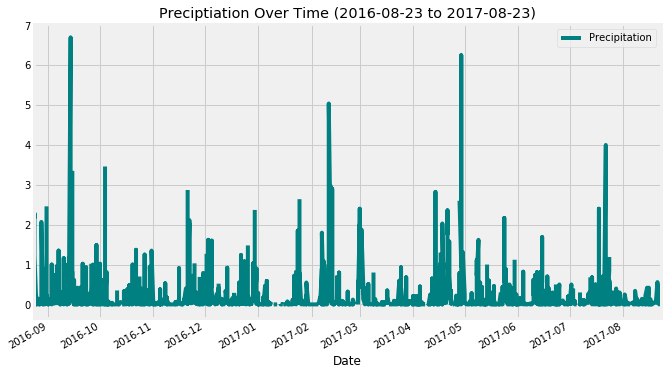

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp = [Measurement.date, Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database
end_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
print(end_date)
start_date = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(start_date.strftime("%Y-%m-%d"))

# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(*prcp).filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_prcp, columns=['Date','Precipitation'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values('Date')
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,6), color="teal")
plt.xlabel("Date")
plt.title("Preciptiation Over Time (2016-08-23 to 2017-08-23)")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = (Measurement.station)
st_count = session.query(stations).count()
print(f"Number of Stations: {st_count}")

Number of Stations: 19550


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_ct = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).all()
station_df = pd.DataFrame(station_ct, columns=['Station', 'Count of Data Points'])
station_df.sort_values('Count of Data Points', ascending=False)



station_df

,Station,Count of Data Points
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

highdata = session.query(Measurement.station, func.count(Measurement.tobs))
.group_by(Measurement.station).order_by(func.count(Measur).desc()).first()
highdata_station= highdata[0]
station_temp = (Measurement.station,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))
top_station = session.query(*station_temp).filter(Measurement.station == highdata_station).all()
top_df = pd.DataFrame(top_station, columns=['Station ID','Lowest Temp', 'Highest Temp', 'Avg Temp'])
top_df

NameError: name 'highdata_station' is not defined

In [ ]:
# # Choose the station with the highest number of temperature observations.
hightemps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
hightemp_station= hightemps[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_station_temp = session.query(Measurement.station, Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
    filter(Measurement.station == hightemp_station).all()
top_temp_df = pd.DataFrame(year_station_temp, columns=['Station ID','Temp'])
top_temp_df

top_temp_df.plot.hist(bins=12, title="Histogram of Temp Observations (2016-08-23 to 2017-08-23)", color="gold", alpha=0.5)
plt.show()


In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-05-30', '2017-06-03')
trip

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='salmon', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    select_column = [Measurement.station, 
               Station.name, 
               Station.latitude, 
               Station.longitude, 
               Station.elevation, 
               Measurement.prcp]

    return session.query(*select_column).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(precipitation('2017-05-30', '2017-06-04'))

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# normals = (daily_normals("05-30"),
#            daily_normals("05-31"),
#            daily_normals("06-01"),
#            daily_normals("06-02"),
#            daily_normals("06-03"),
#            daily_normals("06-04"))
           
# Set the start and end date of the trip
trip_start = dt.datetime.strptime("2017-5-30", "%Y-%m-%d")
trip_end = dt.datetime.strptime("2017-6-04", "%Y-%m-%d")

# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
trip_days = [trip_start + dt.timedelta(days=x) for x in range(0, (trip_end-trip_start).days)]
for days in trip_days:
    print(days.strftime("%m-%d"))

In [ ]:
# Loop through the list of %m-%d strings and calculate the normals for each date
from functools import reduce
import operator 
  
def unpackTuple(normals_t): 
      
    return (reduce(operator.add, normals_t)) 

for days in trip_days:
    normals_t = (daily_normals(days.strftime("%m-%d")))
    print(unpackTuple(normals_t))

 

In [ ]:
normals = []
for result in normals_t:
    row = {}
    #row['date'] = result[0]
    row['min temp'] = result[0]
    row['avg temp'] = result[1]
    row['max temp'] = result[2]
    normals.append(row)

print(normals)

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
